# Image Classification

This project classifies images from the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).  The dataset consists of airplanes, dogs, cats, and other objects. We will preprocess the images, then train a convolutional neural network on all the samples. The images need to be normalized and the labels need to be one-hot encoded.

We are building a convolutional, max pooling, dropout, and fully connected layers.  At the end, we get to see our neural network's predictions on the sample images.

## Get the Data
This following cell downloads the [CIFAR-10 dataset for python](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz).

In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import problem_unittests as tests
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('cifar-10-python.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()


tests.test_folder_path(cifar10_dataset_folder_path)

All files found!


## Explore the Data

The dataset is broken into batches to prevent our machine from running out of memory.  The CIFAR-10 dataset consists of 5 batches, named `data_batch_1`, `data_batch_2`, etc.. Each batch contains the labels and images that are one of the following:
* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck

Understanding a dataset is part of making predictions on the data.  Play around with the code cell below by changing the `batch_id` and `sample_id`. The `batch_id` is the id for a batch (1-5). The `sample_id` is the id for a image and label pair in the batch.



Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 5:
Image - Min Value: 0 Max Value: 252
Image - Shape: (32, 32, 3)
Label - Label Id: 1 Name: automobile


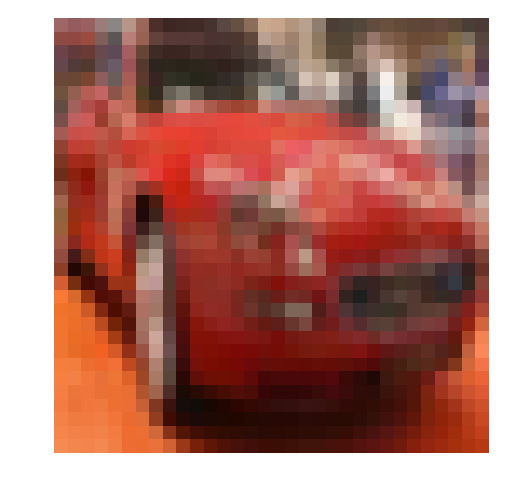

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np

# Explore the dataset
batch_id = 1
sample_id = 5
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

## Implement Preprocess Functions
### Normalize

The cell below has `normalize` function to take in image data, `x`, and return it as a normalized Numpy array. The values should be in the range of 0 to 1, inclusive.  The return object should be the same shape as `x`.

In [3]:
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    x = x.astype('float32')
    x /= 255.0
    return x


tests.test_normalize(normalize)

Tests Passed


### One-hot encode

The input, `x`, are a list of labels.  The function returns the list of labels as One-Hot encoded Numpy array.  The possible values for labels are 0 to 9. The one-hot encoding function should return the same encoding for each value between each call to `one_hot_encode`.


In [4]:
def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    n_labels = 10
    return np.eye(n_labels)[x]


tests.test_one_hot_encode(one_hot_encode)

Tests Passed


## Preprocess all the data and save it
Running the code cell below will preprocess all the CIFAR-10 data and save it to file. The code below also uses 10% of the training data for validation.

In [5]:
# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

# Check Point

This is our first checkpoint.  If we ever decide to come back to this notebook or have to restart the notebook, we can start from here.  The preprocessed data has been saved to disk.

In [6]:
import pickle
import problem_unittests as tests
import helper

# Load the Preprocessed Validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## Build the network

### Input
The neural network needs to read the image data, one-hot encoded labels, and dropout keep probability.


In [7]:
import tensorflow as tf

def neural_net_image_input(image_shape):
    """
    Return a Tensor for a bach of image input
    : image_shape: Shape of the images
    : return: Tensor for image input.
    """

    return tf.placeholder(tf.float32, shape = [None, *image_shape], name = "x")


def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """

    return tf.placeholder(tf.float32, [None, n_classes], name = "y")


def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """

    return tf.placeholder(tf.float32, name = "keep_prob")



tf.reset_default_graph()
tests.test_nn_image_inputs(neural_net_image_input)
tests.test_nn_label_inputs(neural_net_label_input)
tests.test_nn_keep_prob_inputs(neural_net_keep_prob_input)

Image Input Tests Passed.
Label Input Tests Passed.
Keep Prob Tests Passed.


### Convolution and Max Pooling Layer


In [8]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    weights = tf.Variable(tf.truncated_normal([*conv_ksize, x_tensor.get_shape().as_list()[-1], conv_num_outputs]
                                             , stddev=.1), dtype=tf.float32)
                          
                          
    bias = tf.Variable(tf.random_normal(shape=[conv_num_outputs]))

    layer = tf.nn.conv2d(input=x_tensor, filter=weights, strides=[1, *conv_strides, 1], padding='SAME')
    layer = tf.nn.bias_add(layer, bias)

    layer = tf.nn.relu(layer)
    layer = tf.nn.max_pool(layer, ksize=[1, pool_ksize[0], pool_ksize[1], 1]
                           , strides=[1, pool_strides[0], pool_strides[1], 1], padding='SAME')

    return layer


tests.test_con_pool(conv2d_maxpool)


Tests Passed


### Flatten Layer


In [9]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """

    return tf.contrib.layers.flatten(x_tensor)


tests.test_flatten(flatten)

Tests Passed


### Fully-Connected Layer


In [10]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """  
    fully_weight = tf.Variable(tf.truncated_normal(shape=[num_outputs, num_outputs], stddev=0.1), dtype=tf.float32)
    fully_bias = tf.Variable(tf.random_normal(shape=[num_outputs]))

    fully_layer = tf.contrib.layers.fully_connected(x_tensor, num_outputs)
    fully_layer = tf.add(tf.matmul(fully_layer, fully_weight), fully_bias)

    fully_layer = tf.nn.relu(fully_layer)
    return fully_layer


tests.test_fully_conn(fully_conn)

Tests Passed


### Output Layer


In [11]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    out_weight = tf.Variable(tf.truncated_normal(shape=[num_outputs, num_outputs], stddev=0.1), dtype=tf.float32)
    out_bias = tf.Variable(tf.random_normal(shape=[num_outputs]))
    out_layer = tf.contrib.layers.fully_connected(x_tensor, num_outputs)
    out_layer = tf.add(tf.matmul(out_layer, out_weight), out_bias)

    return out_layer


tests.test_output(output)

Tests Passed


### Create Convolutional Model


In [12]:
def conv_net(x, keep_prob):

    x_tensor = x

    conv_num_outputs1 = 32
    conv_num_outputs2 = 128

    conv_ksize = (4,4)
    conv_strides = (2,2)
    pool_ksize = (2,2)
    pool_strides = (2,2)

    conv = conv2d_maxpool (x_tensor, conv_num_outputs1, conv_ksize, conv_strides, pool_ksize, pool_strides)
    conv = conv2d_maxpool (conv, conv_num_outputs2, conv_ksize, conv_strides, pool_ksize, pool_strides)
    conv = tf.nn.dropout (conv, tf.to_float(keep_prob))
    flat = flatten(conv)

    fc = fully_conn(flat, 300)
    fc = fully_conn(fc, 100)

    output_data = output(fc, 10)

    return output_data



##############################
## Build the Neural Network ##
##############################

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

tests.test_conv_net(conv_net)

Neural Network Built!


## Train the Neural Network
### Single Optimization
Implement the function `train_neural_network` to do a single optimization.  The optimization should use `optimizer` to optimize in `session` with a `feed_dict` of the following:
* `x` for image input
* `y` for labels
* `keep_prob` for keep probability for dropout

This function will be called for each batch, so `tf.global_variables_initializer()` has already been called.

Note: Nothing needs to be returned. This function is only optimizing the neural network.

In [13]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """

    session.run(optimizer, feed_dict={x: feature_batch, y: label_batch, keep_prob: keep_probability})



tests.test_train_nn(train_neural_network)

Tests Passed


### Show Stats
Implement the function `print_stats` to print loss and validation accuracy.  Use the global variables `valid_features` and `valid_labels` to calculate validation accuracy.  Use a keep probability of `1.0` to calculate the loss and validation accuracy.

In [14]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    
    loss = session.run(cost, feed_dict={x: feature_batch, y: label_batch, keep_prob: 1.0})
    accuracy = session.run(accuracy, feed_dict={x: valid_features, y: valid_labels, keep_prob: 1.0})
    print("Loss: {}".format(loss))
    print("Accuracy: {}".format(accuracy))

### Hyperparameters
Tune the following parameters:
* Set `epochs` to the number of iterations until the network stops learning or start overfitting
* Set `batch_size` to the highest number that your machine has memory for.  Most people set them to common sizes of memory:
 * 64
 * 128
 * 256
 * ...
* Set `keep_probability` to the probability of keeping a node using dropout

In [15]:
# Tune Parameters
epochs = 20
batch_size = 512
keep_probability = 0.5

### Train on a Single CIFAR-10 Batch
Instead of training the neural network on all the CIFAR-10 batches of data, let's use a single batch. This should save time while you iterate on the model to get a better accuracy.  Once the final validation accuracy is 50% or greater, run the model on all the data in the next section.

In [16]:
print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)

Checking the Training on a Single Batch...
Epoch  1, CIFAR-10 Batch 1:  Loss: 2.5360023975372314
Accuracy: 0.09780000150203705
Epoch  2, CIFAR-10 Batch 1:  Loss: 2.3936915397644043
Accuracy: 0.09700000286102295
Epoch  3, CIFAR-10 Batch 1:  Loss: 2.2661309242248535
Accuracy: 0.1404000073671341
Epoch  4, CIFAR-10 Batch 1:  Loss: 2.1531789302825928
Accuracy: 0.19740000367164612
Epoch  5, CIFAR-10 Batch 1:  Loss: 2.0740301609039307
Accuracy: 0.21799999475479126
Epoch  6, CIFAR-10 Batch 1:  Loss: 2.0341796875
Accuracy: 0.2529999911785126
Epoch  7, CIFAR-10 Batch 1:  Loss: 1.9719724655151367
Accuracy: 0.27059999108314514
Epoch  8, CIFAR-10 Batch 1:  Loss: 1.9016364812850952
Accuracy: 0.3059999942779541
Epoch  9, CIFAR-10 Batch 1:  Loss: 1.8237948417663574
Accuracy: 0.32820001244544983
Epoch 10, CIFAR-10 Batch 1:  Loss: 1.7349445819854736
Accuracy: 0.36500000953674316
Epoch 11, CIFAR-10 Batch 1:  Loss: 1.6840333938598633
Accuracy: 0.37779998779296875
Epoch 12, CIFAR-10 Batch 1:  Loss: 1.63772

### Fully Train the Model
Now that you got a good accuracy with a single CIFAR-10 batch, try it with all five batches.

In [17]:
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  Loss: 2.3097984790802
Accuracy: 0.10859999805688858
Epoch  1, CIFAR-10 Batch 2:  Loss: 2.232724666595459
Accuracy: 0.18479999899864197
Epoch  1, CIFAR-10 Batch 3:  Loss: 2.1611266136169434
Accuracy: 0.18639999628067017
Epoch  1, CIFAR-10 Batch 4:  Loss: 2.0349221229553223
Accuracy: 0.21480000019073486
Epoch  1, CIFAR-10 Batch 5:  Loss: 2.0113320350646973
Accuracy: 0.23160000145435333
Epoch  2, CIFAR-10 Batch 1:  Loss: 2.0259499549865723
Accuracy: 0.24639999866485596
Epoch  2, CIFAR-10 Batch 2:  Loss: 1.926426887512207
Accuracy: 0.2590000033378601
Epoch  2, CIFAR-10 Batch 3:  Loss: 1.8590248823165894
Accuracy: 0.2669999897480011
Epoch  2, CIFAR-10 Batch 4:  Loss: 1.8332762718200684
Accuracy: 0.29319998621940613
Epoch  2, CIFAR-10 Batch 5:  Loss: 1.8567968606948853
Accuracy: 0.29499998688697815
Epoch  3, CIFAR-10 Batch 1:  Loss: 1.8941740989685059
Accuracy: 0.31459999084472656
Epoch  3, CIFAR-10 Batch 2:  Loss: 1.8176320791244507
Accuracy: 0.29219

# Checkpoint
The model has been saved to disk.
## Test Model
Test your model against the test dataset.  This will be your final accuracy. You should have an accuracy greater than 50%. If you don't, keep tweaking the model architecture and parameters.

Testing Accuracy: 0.5833295047283172



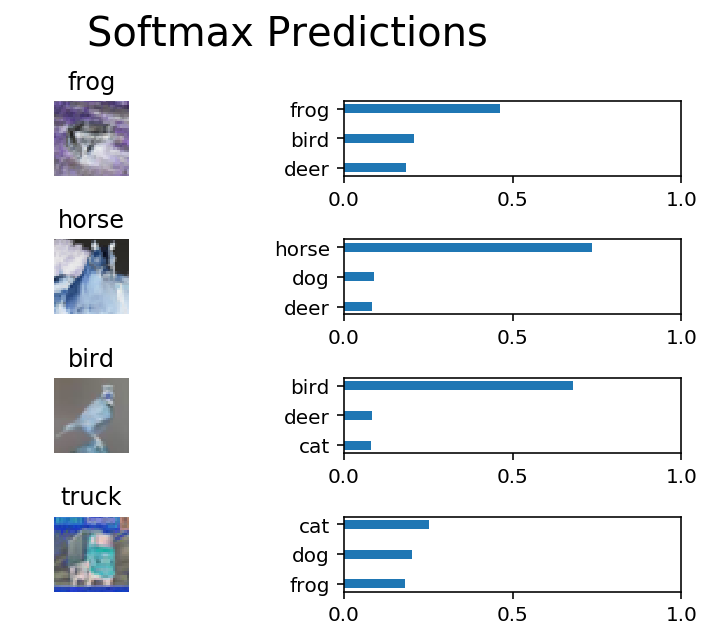

In [18]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_training.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for train_feature_batch, train_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: train_feature_batch, loaded_y: train_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()